In [1]:
pip install weaviate-client

In [129]:
# @title LIBS

from abc import ABC, abstractmethod
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses as loss_functions
from torch.utils.data import DataLoader
from datasets import load_dataset
from typing import List, Tuple, Dict, Optional
from tqdm import tqdm
import json
import re
import matplotlib.pyplot as plt

import weaviate
from weaviate.classes.init import Auth
from weaviate.classes.config import Property, DataType
from weaviate.classes.query import MetadataQuery
from weaviate.exceptions import WeaviateStartUpError

In [130]:
# @title Config

class Config:

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model_name = "sentence-transformers/all-MiniLM-L6-v2"

    # fine-tuning
    batch_size = 16
    epochs = 1

    # weaviate
    weaviate_batch_size = 256
    weaviate_path = "./weaviate_data"

    vector_index_config = weaviate.classes.config.Configure.VectorIndex.hnsw(
        ef_construction=128,
        ef=128,
        max_connections=64,
        vector_cache_max_objects=1000,
        flat_search_cutoff=4000,
        dynamic_ef_min=100,
        dynamic_ef_max=500,
        dynamic_ef_factor=8,
    )

    # Bonus
    func_name_emmbeding = False


In [131]:
# @title CLIENT
# ============================================================================
# WEAVIATE CLIENT
# ============================================================================

def get_weaviate_client():
    """
    Initialize or connect to a local Weaviate embedded instance.
    Automatically detects if an instance is already running.
    """
    try:
        client = weaviate.connect_to_embedded(persistence_data_path=Config.weaviate_path)
        print("✅ Started new embedded Weaviate instance.")
        return client

    except WeaviateStartUpError as e:
        if "already listening on ports" in str(e):
            client = weaviate.connect_to_local(port=8079, grpc_port=50050)
            print("🔄 Connected to existing embedded Weaviate instance.")
            return client
        else:
            raise

In [132]:
# @title Document Schemas
# ============================================================================
# DOCUMENT ABC AND IMPLEMENTATIONS
# ============================================================================

class Document:
    """Universal document class with id and body (can be instantiated directly)"""

    def __init__(self, doc_id: int, body: str):
        self.doc_id = doc_id
        self.body = body

    def get_text_for_embedding(self) -> str:
        """Return text to be embedded (for vector representation)"""
        return self.body

    def to_weaviate_properties(self) -> Dict:
        """Convert document to Weaviate properties"""
        return {
            "doc_id": self.doc_id,
            "body": self.body,
            "doc_type": "universal"
        }

    def get_display_text(self) -> str:
        """Return formatted text for display"""
        return f"{self.doc_id}: {self.body}"

    @staticmethod
    def get_weaviate_schema() -> List:
        """Return Weaviate schema properties for this document type"""
        return [
            Property(name="doc_id", data_type=DataType.INT),
            Property(name="body", data_type=DataType.TEXT),
            Property(name="doc_type", data_type=DataType.TEXT),
        ]

    @classmethod
    def from_weaviate_object(cls, obj) -> 'Document':
        """Create document from Weaviate object"""
        props = obj.properties
        return cls(
            doc_id=props["doc_id"],
            body=props["body"]
        )


class CodeDocument(Document):
    """Document representing a code snippet"""

    def __init__(self, doc_id: int, code: str, language: str = "python"):
        self.doc_id = doc_id
        self.code = code
        self.language = language

    def get_text_for_embedding(self) -> str:
        """Code is embedded directly"""
        return self.code

    def to_weaviate_properties(self) -> Dict:
        return {
            "doc_id": self.doc_id,
            "code": self.code,
            "language": self.language,
            "doc_type": "code"
        }

    def get_display_text(self) -> str:
        return f"[{self.language}] {self.code[:100]}..."

    @staticmethod
    def get_weaviate_schema() -> List:
        return [
            Property(name="doc_id", data_type=DataType.INT),
            Property(name="code", data_type=DataType.TEXT),
            Property(name="language", data_type=DataType.TEXT),
            Property(name="doc_type", data_type=DataType.TEXT),
        ]

    @classmethod
    def from_weaviate_object(cls, obj) -> 'CodeDocument':
        props = obj.properties
        return cls(
            doc_id=props["doc_id"],
            code=props["code"],
            language=props.get("language", "python")
        )


class ArxivDocument(Document):
    """Document representing a scientific paper from ArXiv"""

    def __init__(self, doc_id: int, title: str, abstract: str,
                 categories: List[str] = None):
        self.doc_id = doc_id
        self.title = title
        self.abstract = abstract
        self.categories = categories or []

    def get_text_for_embedding(self) -> str:
        """Combine title and abstract for embedding"""
        return f"{self.title} {self.abstract}"

    def to_weaviate_properties(self) -> Dict:
        return {
            "doc_id": self.doc_id,
            "title": self.title,
            "abstract": self.abstract,
            "categories": self.categories,
            "doc_type": "arxiv"
        }

    def get_display_text(self) -> str:
        cats = ", ".join(self.categories[:3]) if self.categories else "N/A"
        return f"📄 {self.title}\n   {self.abstract[:100]}...\n   🏷️ {cats}"

    @staticmethod
    def get_weaviate_schema() -> List:
        return [
            Property(name="doc_id", data_type=DataType.INT),
            Property(name="title", data_type=DataType.TEXT),
            Property(name="abstract", data_type=DataType.TEXT),
            Property(name="categories", data_type=DataType.TEXT_ARRAY),
            Property(name="doc_type", data_type=DataType.TEXT),
        ]

    @classmethod
    def from_weaviate_object(cls, obj) -> 'ArxivDocument':
        props = obj.properties
        return cls(
            doc_id=props["doc_id"],
            title=props["title"],
            abstract=props["abstract"],
            categories=props.get("categories", [])
        )

In [133]:
# @title Search Engine
# ============================================================================
# UNIFIED SEARCH ENGINE
# ============================================================================

class UnifiedSearchEngine:
    """Single search engine that handles multiple document types"""

    def __init__(self,
                 collection_name: str,
                 documents: List[Document],
                 model_name: str = Config.model_name,):
        """
        Initialize unified search engine

        Args:
            model_name: HuggingFace model for embeddings
            collection_name: Weaviate collection name
        """
        print(f"🚀 Loading model: {model_name}")
        self.model = SentenceTransformer(model_name, device = Config.device)

        self.documents = documents
        self.client = get_weaviate_client()
        self.collection_name = collection_name
        self.collection = None

        self._index_documents()


    def _initialize_collection(self, doc_type: type[Document]):
        """
        Initialize Weaviate collection with schema for document type

        Args:
            doc_type: Document class (CodeDocument, ArxivDocument, etc.)
        """

        if self.client.collections.exists(self.collection_name):
            print(f"🗑️  Deleting existing collection: {self.collection_name}")
            self.client.collections.delete(self.collection_name)

        # Create with schema
        print(f"✨ Creating collection: {self.collection_name}")
        schema = doc_type.get_weaviate_schema()

        self.client.collections.create(
            name=self.collection_name,
            vectorizer_config=None,
            properties=schema,
            vector_index_config= Config.vector_index_config
        )

        self.collection = self.client.collections.get(self.collection_name)
        print(f"✅ Collection ready")


    def _index_documents(self, batch_size=Config.weaviate_batch_size):
        if not self.documents:
            raise ValueError("No documents to index")

        if self.collection is None:
            self._initialize_collection(type(self.documents[0]))

        print(f"\n📥 Indexing {len(self.documents)} documents...")

        texts = [doc.get_text_for_embedding() for doc in self.documents]
        vectors = self.model.encode(
            texts,
            batch_size=batch_size,
            convert_to_numpy=True,
            show_progress_bar=True
        ).astype(np.float32)

        with self.collection.batch.fixed_size(batch_size=batch_size) as batch:
            for doc, vector in tqdm(zip(self.documents, vectors), total=len(self.documents), desc="Uploading"):
                batch.add_object(
                    properties=doc.to_weaviate_properties(),
                    vector=vector
                )

        print(f"✅ Successfully indexed {len(self.documents)} documents")


    def search(self, query: str, top_k: int = 10,
               doc_type_filter: Optional[str] = None) -> List[Tuple[Document, float]]:
        """
        Search for documents matching the query

        Args:
            query: Search query text
            top_k: Number of results to return
            doc_type_filter: Optional filter by doc_type ("code", "arxiv", etc.)

        Returns:
            List of (Document, similarity_score) tuples
        """
        if self.collection is None:
            raise ValueError("No collection initialized. Index documents first.")

        # Encode query
        query_vector = self.model.encode(query).astype(np.float32)

        if doc_type_filter:
            response = self.collection.query.near_vector(
                near_vector=query_vector,
                limit=top_k,
                return_metadata=MetadataQuery(distance=True),
                filters={"doc_type": {"equal": doc_type_filter}}
            )
        else:
            response = self.collection.query.near_vector(
                near_vector=query_vector,
                limit=top_k,
                return_metadata=MetadataQuery(distance=True)
            )


        results = []
        for obj in response.objects:
            doc_type = obj.properties.get("doc_type", "unknown")

            if doc_type == "code":
                doc = CodeDocument.from_weaviate_object(obj)
            elif doc_type == "arxiv":
                doc = ArxivDocument.from_weaviate_object(obj)
            elif doc_type == "universal":
                doc = Document.from_weaviate_object(obj)
            else:
                doc = Document.from_weaviate_object(obj)

            similarity = 1 - obj.metadata.distance
            results.append((doc, similarity))

        return results

    def close(self):
        """Close Weaviate connection"""
        if self.client:
            self.client.close()
            print("🔒 Connection closed")

In [134]:
# @title METRICS
# ============================================================================
# EVALUATION METRICS
# ============================================================================

class RankingMetrics:
    """Ranking metrics for information retrieval"""

    @staticmethod
    def recall_at_k(retrieved_ids: List[int], relevant_ids: List[int], k: int = 10) -> float:
        """Recall@k: proportion of relevant items in top-k"""
        if not relevant_ids:
            return 0.0
        retrieved_k = set(retrieved_ids[:k])
        relevant_set = set(relevant_ids)
        hits = len(retrieved_k.intersection(relevant_set))
        return hits / len(relevant_set)

    @staticmethod
    def mrr_at_k(retrieved_ids: List[int], relevant_ids: List[int], k: int = 10) -> float:
        """Mean Reciprocal Rank@k"""
        relevant_set = set(relevant_ids)
        for rank, doc_id in enumerate(retrieved_ids[:k], start=1):
            if doc_id in relevant_set:
                return 1.0 / rank
        return 0.0

    @staticmethod
    def ndcg_at_k(retrieved_ids: List[int], relevant_ids: List[int], k: int = 10) -> float:
        """Normalized Discounted Cumulative Gain@k"""
        relevant_set = set(relevant_ids)

        dcg = sum(
            (1.0 if doc_id in relevant_set else 0.0) / np.log2(rank + 1)
            for rank, doc_id in enumerate(retrieved_ids[:k], start=1)
        )

        idcg = sum(1.0 / np.log2(rank + 1)
                   for rank in range(1, min(len(relevant_ids), k) + 1))

        return dcg / idcg if idcg > 0 else 0.0

    @staticmethod
    def evaluate(engine: UnifiedSearchEngine,
                 queries: List[str],
                 relevant_docs: List[List[int]],
                 k: int = 10) -> Dict[str, float]:
        """Evaluate search engine on multiple queries"""
        recall_scores = []
        mrr_scores = []
        ndcg_scores = []

        for query, relevant_ids in tqdm(zip(queries, relevant_docs),
                                        total=len(queries),
                                        desc="Evaluating"):
            results = engine.search(query, top_k=k)
            retrieved_ids = [doc.doc_id for doc, _ in results]

            recall_scores.append(
                RankingMetrics.recall_at_k(retrieved_ids, relevant_ids, k)
            )
            mrr_scores.append(
                RankingMetrics.mrr_at_k(retrieved_ids, relevant_ids, k)
            )
            ndcg_scores.append(
                RankingMetrics.ndcg_at_k(retrieved_ids, relevant_ids, k)
            )

        return {
            f'Recall@{k}': np.mean(recall_scores),
            f'MRR@{k}': np.mean(mrr_scores),
            f'NDCG@{k}': np.mean(ndcg_scores)
        }

## Loss Function Selection

For our CoSQA code search task, we use the **`MultipleNegativesRankingLoss`**.

### Why this loss?

1. **In-batch negatives for retrieval tasks**  
   - Each batch contains multiple `(query, positive)` pairs.  
   - Every positive in the batch acts as a negative for all other queries.  
   - This increases the number of negative samples without manually sampling.

2. **Optimizes query-code similarity**  
   - The model learns to bring **query embeddings closer to their relevant code embeddings**.  
   - Non-relevant code embeddings are pushed away automatically.

3. **No need for manual negative sampling**  
   - Manual negative selection is tricky and often suboptimal.  
   - This loss handles it efficiently in-batch.

4. **State-of-the-art for dense retrieval**  
   - Commonly used in models like **Sentence-BERT** and **CodeBERT** for retrieval tasks.  
   - Works well for datasets where each query has few relevant documents (like CoSQA).

5. **Efficient and scalable**  
   - In-batch negatives allow effective training per step.  
   - Scales well on GPU with large batches.


In [135]:
# @title Fine-tuning
# ============================================================================
# FINE-TUNING
# ============================================================================

def fine_tune_model(
    base_model: SentenceTransformer,
    train_data: List[Dict],
    num_epochs: int = 1,
    batch_size: int = 16,
    output_path: str = "./finetuned_model",
) -> Tuple[SentenceTransformer, List[float]]:
    """
    Fine-tune using MultipleNegativesRankingLoss

    Args:
        base_model: Pre-trained model
        train_data: List of {"query": str, "code": str}
        num_epochs: Training epochs
        batch_size: Batch size
        output_path: Save path

    Returns:
        (finetuned_model, loss_history)
    """

    print(f"\n🔧 Fine-tuning on {len(train_data)} examples...")
    print(f"   Loss: MultipleNegativesRankingLoss")
    print(f"   Batch size: {batch_size}, Epochs: {num_epochs}")

    train_examples = [
        InputExample(texts=[item['query'], item['code']])
        for item in train_data
    ]

    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
    train_loss = loss_functions.MultipleNegativesRankingLoss(base_model)

    # 🧩 Track losses and log progress
    class LossTracker:
        def __init__(self, log_every=100):
            self.losses = []
            self.step = 0
            self.log_every = log_every

        def __call__(self, loss_value, epoch, step):
            self.losses.append(loss_value)
            self.step += 1
            if self.step % self.log_every == 0:
                print(f"🧠 Step {self.step} | Epoch {epoch} | Loss: {loss_value:.4f}")

    callback = LossTracker()

    base_model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=num_epochs,
        warmup_steps=100,
        output_path=output_path,
        show_progress_bar=True,
        callback=callback
    )

    print(f"\n✅ Model fine-tuned and saved to {output_path}")
    return base_model, callback.losses

In [136]:
# @title DATA LOADING
# ============================================================================
# DATA LOADING
# ============================================================================

def load_arxiv_documents(num_samples: int = 1000) -> List[ArxivDocument]:
    """Load ArXiv papers as ArxivDocument objects"""
    print("\n" + "="*80)
    print("📚 Loading ArXiv Papers")
    print("="*80)

    dataset = load_dataset("gfissore/arxiv-abstracts-2021", split=f"train[:{num_samples}]")

    documents = []
    for idx, item in enumerate(dataset):
        doc = ArxivDocument(
            doc_id=idx,
            title=item["title"],
            abstract=item["abstract"],
            categories=item.get("categories", [])
        )
        documents.append(doc)

    print(f"✅ Loaded {len(documents)} papers")
    return documents

def extract_func_name(code_text: str) -> str | None:
    """Extracts the first function name from a Python code snippet."""
    match = re.search(r"def\s+([A-Za-z_]\w*)\s*\(", code_text)
    return match.group(1) if match else None


def load_cosqa_documents(num_samples: Optional[int] = 1000) -> Tuple[List[CodeDocument], List[str], List[List[int]], List[Dict], Dict[str, int]]:
    """
    Load CoSQA dataset from CoIR-Retrieval

    This dataset has 3 parts:
    - queries: Natural language queries
    - corpus: Code snippets
    - qrels: Query-to-corpus mappings

    Returns:
        (code_documents, queries, relevant_docs, train_data, corpus_id_to_idx)
    """
    print("\n" + "="*80)
    print("💻 Loading CoSQA Dataset (CoIR-Retrieval)")
    print("="*80)

    print("📥 Loading queries...")
    queries_dataset = load_dataset("CoIR-Retrieval/cosqa", "queries", split="queries")

    print("📥 Loading corpus...")
    corpus_dataset = load_dataset("CoIR-Retrieval/cosqa", "corpus", split="corpus")

    print("📥 Loading qrels (mappings)...")
    qrels_dataset = load_dataset("CoIR-Retrieval/cosqa", "default", split="train")

    if num_samples:
        queries_dataset = queries_dataset.select(range(min(num_samples, len(queries_dataset))))
        print(f"   Limited to {len(queries_dataset)} queries")

    print("\n🔨 Building corpus...")
    corpus_id_to_idx = {}
    documents = []

    for idx, item in enumerate(tqdm(corpus_dataset, desc="Processing corpus")):
        corpus_id = item['_id']
        code = extract_func_name(item['text']) if Config.func_name_emmbeding else item['text']

        doc = CodeDocument(
            doc_id=idx,
            code=code,
            language="python"
        )
        documents.append(doc)
        corpus_id_to_idx[corpus_id] = idx

    print(f"✅ Loaded {len(documents)} code documents")


    print("\n🔨 Building queries...")
    queries = []
    query_ids = []

    for item in tqdm(queries_dataset, desc="Processing queries"):
        query_id = item['_id']
        query_text = item['text']
        queries.append(query_text)
        query_ids.append(query_id)

    print(f"✅ Loaded {len(queries)} queries")

    print("\n🔨 Building relevance mappings...")
    query_id_to_idx = {qid: idx for idx, qid in enumerate(query_ids)}
    relevant_docs = [[] for _ in range(len(queries))]

    for item in tqdm(qrels_dataset, desc="Processing mappings"):
        query_id = item['query-id']
        corpus_id = item['corpus-id']
        score = item.get('score', 1)

        if query_id in query_id_to_idx and corpus_id in corpus_id_to_idx:
            query_idx = query_id_to_idx[query_id]
            doc_idx = corpus_id_to_idx[corpus_id]
            relevant_docs[query_idx].append(doc_idx)

    filtered_queries = []
    filtered_relevant = []
    for query, rel_docs in zip(queries, relevant_docs):
        if rel_docs:
            filtered_queries.append(query)
            filtered_relevant.append(rel_docs)

    print(f"✅ {len(filtered_queries)} queries with relevant documents")

    print("\n🔨 Building training data...")
    train_data = []
    for query, rel_docs in zip(filtered_queries, filtered_relevant):
        doc_idx = rel_docs[0]
        train_data.append({
            "query": query,
            "code": documents[doc_idx].code
        })

    print(f"✅ Created {len(train_data)} training examples")

    print("\n📊 CoSQA Dataset Summary:")
    print(f"   Total corpus: {len(documents)} code snippets")
    print(f"   Total queries: {len(filtered_queries)}")
    print(f"   Avg relevant docs per query: {np.mean([len(r) for r in filtered_relevant]):.2f}")
    print(f"   Training examples: {len(train_data)}")

    return documents, filtered_queries, filtered_relevant, train_data, corpus_id_to_idx

In [137]:
# @title DEMOS
# ============================================================================
# DEMO FUNCTIONS
# ============================================================================

def demo_arxiv_search():
    """Demo: Search scientific papers"""
    print("\n" + "="*80)
    print("🔬 DEMO 1: Scientific Paper Search")
    print("="*80)

    papers = load_arxiv_documents(num_samples=10_000)

    engine = UnifiedSearchEngine(collection_name="Arxiv_abstracts", documents=papers)

    queries = [
        "machine learning neural networks",
        "quantum computing algorithms",
        "biology and artificial intelligence"
    ]

    for query in queries:
        print(f"\n🔍 Query: '{query}'")
        print("-" * 80)
        results = engine.search(query, top_k=3)

        for rank, (doc, score) in enumerate(results, 1):
            print(f"\n{rank}. [Score: {score:.3f}]")
            print(f"   {doc.get_display_text()}")

    engine.close()


def demo_code_search():
    """Demo: Search code snippets"""
    print("\n" + "="*80)
    print("💻 DEMO 2: Code Search")
    print("="*80)

    code_docs = [
        CodeDocument(0, "def add(a, b):\n    return a + b", "python"),
        CodeDocument(1, "def multiply(x, y):\n    return x * y", "python"),
        CodeDocument(2, "def find_max(arr):\n    return max(arr)", "python"),
        CodeDocument(3, "def sort_list(items):\n    return sorted(items)", "python"),
        CodeDocument(4, "async def fetch_data(url):\n    response = await client.get(url)\n    return response.json()", "python"),
    ]

    engine = UnifiedSearchEngine(collection_name="Demo_Code", documents=code_docs)

    queries = [
        "function to add two numbers",
        "asynchronous http request"
    ]

    for query in queries:
        print(f"\n🔍 Query: '{query}'")
        print("-" * 80)
        results = engine.search(query, top_k=3)

        for rank, (doc, score) in enumerate(results, 1):
            print(f"\n{rank}. [Score: {score:.3f}]")
            print(f"   {doc.get_display_text()}")

    engine.close()


# ============================================================================
# MAIN EVALUATION ON COSQA
# ============================================================================

def load_and_split_cosqa(num_samples: int = 20_000):
    print("\n" + "=" * 80)
    print("📦 STEP 1: Load and Split CoSQA Dataset")
    print("=" * 80)

    code_docs, queries, relevant_docs, train_data, corpus_map = load_cosqa_documents(num_samples=num_samples)

    split_idx = int(len(queries) * 0.8)
    test_queries = queries[split_idx:]
    test_relevant = relevant_docs[split_idx:]
    train_subset = train_data[:split_idx]

    print(f"\n📊 Data split:")
    print(f"   Train: {len(train_subset)} examples")
    print(f"   Test: {len(test_queries)} examples")
    print(f"   Total corpus: {len(code_docs)} documents")

    return code_docs, train_subset, test_queries, test_relevant


def run_baseline_evaluation(code_docs, test_queries, test_relevant):
    print("\n" + "-" * 80)
    print("📈 STEP 2: Baseline Model Evaluation")
    print("-" * 80)

    baseline_engine = UnifiedSearchEngine(collection_name="CoSQA", documents=code_docs)

    metrics = RankingMetrics.evaluate(
        baseline_engine, test_queries, test_relevant, k=10
    )

    print("\n🎯 Baseline Results:")
    for metric, score in metrics.items():
        print(f"   {metric}: {score:.4f}")

    model = baseline_engine.model
    baseline_engine.close()

    return model, metrics


def run_finetuned_evaluation(base_model, code_docs, train_subset, test_queries, test_relevant):
    print("\n" + "-" * 80)
    print("🔧 STEP 3: Fine-tuning Model")
    print("-" * 80)

    print("\n💡 Why MultipleNegativesRankingLoss?")
    print("   ✓ Uses in-batch negatives (efficient)")
    print("   ✓ Optimizes query-code similarity")
    print("   ✓ No explicit negative sampling")
    print("   ✓ State-of-the-art for retrieval")

    finetuned_model, losses = fine_tune_model(
        base_model,
        train_subset,
        num_epochs=Config.epochs,
        batch_size=Config.batch_size,
        output_path="./finetuned_cosqa_model"
    )

    if losses:
        with open("training_losses.json", "w") as f:
            json.dump({"losses": losses, "final_loss": losses[-1]}, f)
        print(f"\n📈 Final loss: {losses[-1]:.4f}")

    print("\n" + "-" * 80)
    print("📈 Fine-tuned Model Evaluation")
    print("-" * 80)

    finetuned_engine = UnifiedSearchEngine(collection_name="CoSQA", documents=code_docs)
    finetuned_engine.model = finetuned_model

    finetuned_metrics = RankingMetrics.evaluate(
        finetuned_engine, test_queries, test_relevant, k=10
    )
    finetuned_engine.close()

    print("\n🎯 Fine-tuned Results:")
    for metric, score in finetuned_metrics.items():
        print(f"   {metric}: {score:.4f}")

    return finetuned_model, finetuned_metrics, losses


def compare_results(baseline_metrics, finetuned_metrics):
    print("\n" + "=" * 80)
    print("📊 STEP 4: IMPROVEMENT SUMMARY")
    print("=" * 80)

    for metric in baseline_metrics:
        baseline = baseline_metrics[metric]
        finetuned = finetuned_metrics[metric]
        improvement = ((finetuned - baseline) / baseline * 100) if baseline > 0 else 0
        arrow = "↑" if improvement > 0 else "↓" if improvement < 0 else "→"
        print(f"   {metric:12s}: {baseline:.4f} → {finetuned:.4f} {arrow} ({improvement:+.2f}%)")


def run_cosqa_pipeline():
    """Full pipeline: load, baseline, fine-tune, compare"""
    code_docs, train_subset, test_queries, test_relevant = load_and_split_cosqa(num_samples=20_000)
    base_model, baseline_metrics = run_baseline_evaluation(code_docs, test_queries, test_relevant)
    finetuned_model, finetuned_metrics, losses = run_finetuned_evaluation(base_model, code_docs, train_subset, test_queries, test_relevant)
    compare_results(baseline_metrics, finetuned_metrics)

    print("\n" + "=" * 80)
    print("✅ ALL COMPLETE!")
    print("=" * 80)

    return {
        "baseline": baseline_metrics,
        "finetuned": finetuned_metrics,
        "losses": losses
    }


In [138]:
def plot_mean_losses(losses: List[float]):
    interval = 100
    mean_losses = [np.mean(losses[i:i+interval]) for i in range(0, len(losses), interval)]
    steps = np.arange(interval, len(losses)+1, interval)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(steps, mean_losses, marker='o', linestyle='-', color='blue', label='Mean Loss per 100 steps')
    plt.xlabel("Training Steps")
    plt.ylabel("Mean Loss")
    plt.title("Training Loss Curve (Mean per 100 Steps)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

🚀 UNIFIED SEARCH ENGINE
   Single engine, multiple document types (ABC pattern)

🔬 DEMO 1: Scientific Paper Search

📚 Loading ArXiv Papers
✅ Loaded 10000 papers
🚀 Loading model: sentence-transformers/all-MiniLM-L6-v2


INFO:weaviate-client:Started /root/.cache/weaviate-embedded: process ID 29753


✅ Started new embedded Weaviate instance.
🗑️  Deleting existing collection: Arxiv_abstracts
✨ Creating collection: Arxiv_abstracts
✅ Collection ready

📥 Indexing 10000 documents...


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Uploading: 100%|██████████| 10000/10000 [00:10<00:00, 919.65it/s]


✅ Successfully indexed 10000 documents

🔍 Query: 'machine learning neural networks'
--------------------------------------------------------------------------------

1. [Score: 0.443]
   📄 On-Line Condition Monitoring using Computational Intelligence
     This paper presents bushing condition monitoring frameworks that use
multi-layer perceptrons (MLP)...
   🏷️ cs.AI

2. [Score: 0.434]
   📄 Artificial Intelligence for Conflict Management
     Militarised conflict is one of the risks that have a significant impact on
society. Militarised In...
   🏷️ cs.AI

3. [Score: 0.434]
   📄 Option Pricing Using Bayesian Neural Networks
     Options have provided a field of much study because of the complexity
involved in pricing them. Th...
   🏷️ cs.CE cs.NE

🔍 Query: 'quantum computing algorithms'
--------------------------------------------------------------------------------

1. [Score: 0.773]
   📄 The Road to Quantum Artificial Intelligence
     This paper overviews the basic principles and rec

INFO:weaviate-client:Started /root/.cache/weaviate-embedded: process ID 29980


✅ Started new embedded Weaviate instance.
🗑️  Deleting existing collection: Demo_Code
✨ Creating collection: Demo_Code
✅ Collection ready

📥 Indexing 5 documents...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 5/5 [00:00<00:00, 5775.69it/s]


✅ Successfully indexed 5 documents

🔍 Query: 'function to add two numbers'
--------------------------------------------------------------------------------

1. [Score: 0.677]
   [python] def add(a, b):
    return a + b...

2. [Score: 0.337]
   [python] def multiply(x, y):
    return x * y...

3. [Score: 0.091]
   [python] def find_max(arr):
    return max(arr)...

🔍 Query: 'asynchronous http request'
--------------------------------------------------------------------------------

1. [Score: 0.551]
   [python] async def fetch_data(url):
    response = await client.get(url)
    return response.json()...

2. [Score: 0.001]
   [python] def add(a, b):
    return a + b...

3. [Score: -0.002]
   [python] def sort_list(items):
    return sorted(items)...
🔒 Connection closed

📦 STEP 1: Load and Split CoSQA Dataset

💻 Loading CoSQA Dataset (CoIR-Retrieval)
📥 Loading queries...
📥 Loading corpus...
📥 Loading qrels (mappings)...
   Limited to 20000 queries

🔨 Building corpus...


Processing corpus: 100%|██████████| 20604/20604 [00:01<00:00, 14619.86it/s]


✅ Loaded 20604 code documents

🔨 Building queries...


Processing queries: 100%|██████████| 20000/20000 [00:01<00:00, 15829.91it/s]


✅ Loaded 20000 queries

🔨 Building relevance mappings...


Processing mappings: 100%|██████████| 19604/19604 [00:00<00:00, 30825.17it/s]


✅ 19604 queries with relevant documents

🔨 Building training data...
✅ Created 19604 training examples

📊 CoSQA Dataset Summary:
   Total corpus: 20604 code snippets
   Total queries: 19604
   Avg relevant docs per query: 1.00
   Training examples: 19604

📊 Data split:
   Train: 15683 examples
   Test: 3921 examples
   Total corpus: 20604 documents

--------------------------------------------------------------------------------
📈 STEP 2: Baseline Model Evaluation
--------------------------------------------------------------------------------
🚀 Loading model: sentence-transformers/all-MiniLM-L6-v2


INFO:weaviate-client:Started /root/.cache/weaviate-embedded: process ID 30067


✅ Started new embedded Weaviate instance.
🗑️  Deleting existing collection: CoSQA
✨ Creating collection: CoSQA
✅ Collection ready

📥 Indexing 20604 documents...


Batches:   0%|          | 0/81 [00:00<?, ?it/s]

Uploading: 100%|██████████| 20604/20604 [00:16<00:00, 1219.86it/s]


✅ Successfully indexed 20604 documents


Evaluating: 100%|██████████| 3921/3921 [00:43<00:00, 89.90it/s]



🎯 Baseline Results:
   Recall@10: 0.4124
   MRR@10: 0.1713
   NDCG@10: 0.2273


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


🔒 Connection closed

--------------------------------------------------------------------------------
🔧 STEP 3: Fine-tuning Model
--------------------------------------------------------------------------------

💡 Why MultipleNegativesRankingLoss?
   ✓ Uses in-batch negatives (efficient)
   ✓ Optimizes query-code similarity
   ✓ No explicit negative sampling
   ✓ State-of-the-art for retrieval

🔧 Fine-tuning on 15683 examples...
   Loss: MultipleNegativesRankingLoss
   Batch size: 16, Epochs: 1


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.087700



✅ Model fine-tuned and saved to ./finetuned_cosqa_model

--------------------------------------------------------------------------------
📈 Fine-tuned Model Evaluation
--------------------------------------------------------------------------------
🚀 Loading model: sentence-transformers/all-MiniLM-L6-v2


INFO:weaviate-client:Started /root/.cache/weaviate-embedded: process ID 30913


✅ Started new embedded Weaviate instance.
🗑️  Deleting existing collection: CoSQA
✨ Creating collection: CoSQA
✅ Collection ready

📥 Indexing 20604 documents...


Batches:   0%|          | 0/81 [00:00<?, ?it/s]

Uploading: 100%|██████████| 20604/20604 [00:21<00:00, 954.79it/s]


✅ Successfully indexed 20604 documents


Evaluating: 100%|██████████| 3921/3921 [00:42<00:00, 91.70it/s] 


🔒 Connection closed

🎯 Fine-tuned Results:
   Recall@10: 0.4246
   MRR@10: 0.1728
   NDCG@10: 0.2313

📊 STEP 4: IMPROVEMENT SUMMARY
   Recall@10   : 0.4124 → 0.4246 ↑ (+2.97%)
   MRR@10      : 0.1713 → 0.1728 ↑ (+0.83%)
   NDCG@10     : 0.2273 → 0.2313 ↑ (+1.76%)

✅ ALL COMPLETE!


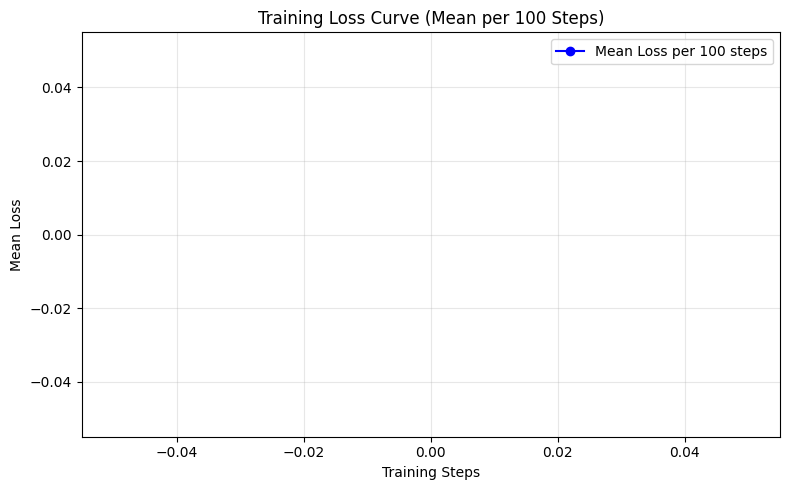


✅ ALL COMPLETE!


In [139]:
# @title MAIN
# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    print("="*80)
    print("🚀 UNIFIED SEARCH ENGINE")
    print("   Single engine, multiple document types (ABC pattern)")
    print("="*80)

    try:
        # Demo 1: Papers
        demo_arxiv_search()

        # Demo 2: Code
        demo_code_search()

        # Main evaluation (baseline and finetuned)
        results = run_cosqa_pipeline()
        plot_mean_losses(results["losses"])

        print("\n" + "="*80)
        print("✅ ALL COMPLETE!")
        print("="*80)

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

## Effect of Using Function Names Only

Using only function names instead of full function bodies significantly reduces retrieval performance for code search.  

- **Controlled by configuration**: The `Config.func_name_embedding = False` flag determines whether the model uses full function bodies (`False`) or only function names (`True`) as input text for embeddings.  
- **Less context for embeddings**: Function names alone provide very limited semantic information, making it harder for the model to match queries to the correct functions.  
- **Generic names increase ambiguity**: Many functions have common names like `get_data` or `set_value`, which appear in multiple places, leading to more false positives.  
- **Metrics drop**: Recall, MRR, and NDCG are roughly **halved** compared to using full function bodies.  


## Effect of Updating Vector Storage Hyperparameters

The retrieval metrics are sensitive to the **vector storage (HNSW) hyperparameters**:

Higher efConstruction, ef, and maxConnections → better nearest neighbor search.

Improves metrics such as Recall@10, MRR@10, NDCG@10.

Typical effect: Recall can increase by ~5% with these settings.


- Controlled by `Config.vector_index_config`:

```python
Config.vector_index_config = weaviate.classes.config.Configure.VectorIndex.hnsw(
    ef_construction=128,
    ef=128,
    max_connections=64,
    vector_cache_max_objects=1000,
    flat_search_cutoff=4000,
    dynamic_ef_min=100,
    dynamic_ef_max=500,
    dynamic_ef_factor=8,
)

